# Example notebook: Studying and mitigating the effects of data drifts on ML model performance

This notebook is part of the supporting information to the manuscript entitled: *Studying and mitigating the effects of data drifts on ML model performance at the example of chemical toxicity data*
* Authors: A. Morger, M. Garcia de Lomana, U. Norinder, F. Svensson, J. Kirchmair, M. Mathea, and A. Volkamer
* Last updated: August 2021

In this notebook, the use of the Conformal prediction (CP) classes to study and mitigate the effects of data drifts on model calibration are demonstrated. The ChEMBL dataset, as used in the manuscript, for endpoint "CHEMBL228" is loaded as example. You can also exchange it with your own data.

### Import packages and modules

In [1]:
import pandas as pd
import numpy as np
import sys
import tarfile

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

In [3]:
from nonconformist.nc import InverseProbabilityErrFunc, NcFactory

In [4]:
from continuous_calibration import (
StratifiedRatioSampler, BalancedStratifiedRatioSampler, CrossValidationSampler, InductiveConformalPredictor, 
    ContinuousCalibrationAggregatedConformalPredictor, CrossValidator
)
from continuous_calibration_helper_functions import draw_scatter_plot_one_endpoint, create_umap_data, plot_umap

### Define paths and parameters

In [5]:
data_path = "../data/chembl_chembio_descriptors.tar.bz2"
data_path = "../data/CHEMBL228_chembio_normalizedDesc.csv.tar.bz2"
time_split_threshold_path = "../data/data_size_chembio_chembl.csv"

Choose an endpoint. 

In [6]:
# Note that due to the size of the datasets, 
# only one dataset for ChEMBL228 endpoint is available from GitHub.
# Data for other ChEMBL endpoints can be downloaded from Zenodo (link_to_zenodo).
endpoint = "CHEMBL228"

Define parameters for machine learning and conformal prediction.

In [7]:
ntrees = 50  # 500
n_folds_acp = 3  # 20
ratio_sampler = StratifiedRatioSampler(n_folds=n_folds_acp)

Define UMAP parameters for compound descriptor space analysis.

In [8]:
descriptors = "chembio"
n_neighbors = 100
min_distances = 0.8
distance_metric = "euclidean"
umap_colours = ["navy", "magenta", "orangered", "green"]

### Load and preprocess the data

Due to the size of the datasets, which contain the precalculated chembio descriptors, the example data for ChEMBL228 endpoint was deposited on GitHub as compressed file. 

The data contains:
* Molecule ChEMBL ID
* SMILES
* Publication date
* Binary activity (0 or 1)
* Precalculated ChemBio descriptors

In [9]:
data = pd.read_csv(data_path, compression='bz2', index_col=0)
data.head()

,CHEMBL228_bioactivity,molecule_chembl_id,year,Strongest ACIDIC pKa 1,Strongest ACIDIC pKa 2,Strongest BASIC pKa 1,Strongest BASIC pKa 2,SlogP,SMR,LabuteASA,...,p0-ToxCast_TOX21_p53_BLA_p5_ratio_InVitro,p1-ToxCast_TOX21_p53_BLA_p5_ratio_InVitro,p0-ToxCast_UPITT_HCI_U2OS_AR_TIF2_Nucleoli_Agonist_InVitro,p1-ToxCast_UPITT_HCI_U2OS_AR_TIF2_Nucleoli_Agonist_InVitro,p0-ToxCast_UPITT_HCI_U2OS_AR_TIF2_Nucleoli_Antagonist_InVitro,p1-ToxCast_UPITT_HCI_U2OS_AR_TIF2_Nucleoli_Antagonist_InVitro,p0-ToxCast_UPITT_HCI_U2OS_AR_TIF2_Nucleoli_Cytoplasm_Ratio_Antagonist_InVitro,p1-ToxCast_UPITT_HCI_U2OS_AR_TIF2_Nucleoli_Cytoplasm_Ratio_Antagonist_InVitro,p0-ToxCast_NCCT_HEK293T_CellTiterGLO_InVitro,p1-ToxCast_NCCT_HEK293T_CellTiterGLO_InVitro
CHEMBL228_chembio_normalizedDesc.csv,,,,,,,,,,,,,,,,,,,,,
Brc1cc(O[C@H]2C[C@@H]3CC[C@H](C2)N3)cc(-c2ccccc2)c1,0.0,CHEMBL1644601,2011.0,-2.809112e-15,5.939682e-15,1.302647,-3.673721e-16,0.559000,-0.269953,-0.311607,...,-0.271379,-0.124748,-0.817191,0.782127,-0.588356,0.537403,-0.234571,0.169539,-0.779707,0.794822
Brc1ccc(N2CCN(CCCCOc3ccc4ccccc4c3)CC2)cc1,0.0,CHEMBL4294090,2018.0,-2.809112e-15,5.939682e-15,-0.469983,-1.712712e+00,1.195275,0.840088,0.625818,...,-0.748681,0.594661,0.508205,-0.604907,-0.131702,-0.073389,-0.288971,0.227672,-0.884506,1.350940
Brc1ccc(N2CCN(CCCN3CCC(Cc4ccccc4)CC3)CC2)cc1,0.0,CHEMBL3775012,2016.0,-2.809112e-15,5.939682e-15,0.383832,2.511407e+00,0.667995,1.046026,0.854395,...,-0.505029,0.078336,-0.605172,0.579285,-0.321704,0.146703,-1.160155,1.278064,-0.884357,1.210984
Brc1ccc(N2CCN(CCCOc3ccc4ccccc4c3)CC2)cc1,1.0,CHEMBL4283496,2018.0,-2.809112e-15,5.939682e-15,-0.790863,-1.698674e+00,0.887168,0.658979,0.460180,...,-0.540919,0.204206,0.713899,-0.785441,-0.086008,-0.127980,-0.187862,0.127924,-0.907245,1.275077
Brc1ccc(N2CCN(CCN3CCC(Cc4ccccc4)CC3)CC2)cc1,0.0,CHEMBL3775085,2016.0,-2.809112e-15,5.939682e-15,0.102462,1.316044e+00,0.359888,0.864918,0.688757,...,-0.228433,-0.201849,-0.564613,0.373680,-0.233987,-0.000591,-1.045112,1.088714,-0.886296,1.230637


If you want to run the example notebook for any other ChEMBL endpoint, a compressed file with all ChEMBL datasets used in this work can be downloaded from [Zenodo](link_to_zenodo) as tar.bz2 files. Change the `endpoint` in Cell 6 and uncomment the following three cells.

Drop rows without any information on the publication date. 

In [10]:
# The publication date is required for temporal data splitting.
data.dropna(subset=["year"], inplace=True)

Define the labels for the ML experiment, i.e., the measured binarized bioactivities.

In [11]:
y = data[f"{endpoint}_bioactivity"].values
y

array([0., 0., 0., ..., 1., 1., 1.])

Define feature columns from the ChemBio descriptor, i.e., p-values and chemical descriptors.

In [12]:
# Any other columns present in the dataset, but not part of the descriptors, are explicitly excluded.

columns = [
            col
            for col in data.columns
            if (not col.startswith("Toxicity"))  # Exclude in vivo labels used for p-values
            and (col != f"{endpoint}_bioactivity")  # Exclude ChEMBL bioactivity labels
            and (col != "SMILES (Canonical)")  # Exclude canonical smiles
            and (col != "smiles")  # Exclude smiles
            and (col != "year")  # Exclude publication year
            and (col != "molecule_chembl_id")  # Exclude molecule ChEMBL id
        ]

X = data[columns].values
X

array([[-2.80911163e-15,  5.93968226e-15,  1.30264678e+00, ...,
         1.69538682e-01, -7.79707476e-01,  7.94822309e-01],
       [-2.80911163e-15,  5.93968226e-15, -4.69982792e-01, ...,
         2.27671782e-01, -8.84505678e-01,  1.35093976e+00],
       [-2.80911163e-15,  5.93968226e-15,  3.83831965e-01, ...,
         1.27806444e+00, -8.84357296e-01,  1.21098428e+00],
       ...,
       [-2.80911163e-15,  5.93968226e-15,  1.11010701e+00, ...,
        -7.72733450e-01,  1.32371173e+00, -1.39837780e+00],
       [-2.80911163e-15,  5.93968226e-15,  7.09563407e-01, ...,
        -2.01146873e+00,  2.53051914e-01, -5.89647388e-01],
       [-2.80911163e-15,  5.93968226e-15, -1.14389134e-01, ...,
        -1.45764980e+00,  1.71728142e+00, -1.53578739e+00]])

Collect the publication years in an arry. This information will be used for temporal data splitting.

In [13]:
years = data["year"].values
years

array([2011., 2018., 2016., ..., 2018., 2009., 2014.])

### Split data

Here, we implement a time-split to separate the data in four subsets based on the publication year:
* training set
* update 1 set
* update 2 set
* holdout set

#### Load dataframe defining time-split thresholds per endpoint
The `time_split_threshold_path` variable holds the precalculated information which year is used per data set to create the time split data while retaining specific ratios (see manuscript for more detail).

In [14]:
splits_df = pd.read_csv(time_split_threshold_path, index_col=0, 
                        usecols=["chembl_id", "train_thresh", "update1_thresh", "update2_thresh"])
splits_df

,train_thresh,update1_thresh,update2_thresh
chembl_id,,,
CHEMBL220,2014,2016,2017
CHEMBL4078,2014,2015,2016
CHEMBL5763,2015,2016,2017
CHEMBL203,2012,2014,2016
CHEMBL206,2006,2012,2016
CHEMBL279,2010,2013,2014
CHEMBL230,2010,2013,2015
CHEMBL340,2012,2014,2015
CHEMBL240,2012,2014,2016


In [15]:
splits_df.index

Index(['CHEMBL220', 'CHEMBL4078', 'CHEMBL5763', 'CHEMBL203', 'CHEMBL206',
       'CHEMBL279', 'CHEMBL230', 'CHEMBL340', 'CHEMBL240', 'CHEMBL2039',
       'CHEMBL222', 'CHEMBL228'],
      dtype='object', name='chembl_id')

Get year thresholds to split the data for the selected endpoint.

In [16]:
thresholds = splits_df["train_thresh"][endpoint], splits_df["update1_thresh"][endpoint], splits_df["update2_thresh"][endpoint]
thresholds

(2009, 2011, 2014)

Do the splitting based on the threshold.

In [17]:
# Collect the respective indices based on the threshold
mask_train = years <= thresholds[0]
mask_update1 = (years > thresholds[0]) & (years <= thresholds[1])
mask_update2 = (years > thresholds[1]) & (years <= thresholds[2])
mask_holdout = years > thresholds[2]

# Split the data accordingly
X_train, y_train = X[mask_train], y[mask_train]
X_update1, y_update1 = X[mask_update1], y[mask_update1]
X_update2, y_update2 = X[mask_update2], y[mask_update2]
X_holdout, y_holdout = X[mask_holdout], y[mask_holdout]

Inspect the data subsets.

In [18]:
# Check shape of the arrays
print(f"Training set shape: y={y_train.shape}, X={X_train.shape}")
print(f"Update1 set shape: y={y_update1.shape}, X={X_update1.shape}")
print(f"Update2 set shape: y={y_update2.shape}, X={X_update2.shape}")
print(f"Holdout set shape: y={y_holdout.shape}, X={X_holdout.shape}")

Training set shape: y=(1100,), X=(1100, 2344)
Update1 set shape: y=(470,), X=(470, 2344)
Update2 set shape: y=(266,), X=(266, 2344)
Holdout set shape: y=(275,), X=(275, 2344)


In [19]:
# Check if we have actives and inactives in all datasets
print(f"Active compounds training set: {y_train.sum()}")
print(f" update1 set: {y_update1.sum()}\n update2 set: {y_update2.sum()}\n holdout set: {y_holdout.sum()}")

Active compounds training set: 858.0
 update1 set: 373.0
 update2 set: 235.0
 holdout set: 196.0


### Prepare the Aggregated Conformal Predictor (ACP)

In [20]:
clf = RandomForestClassifier(n_estimators=ntrees)
error_function = InverseProbabilityErrFunc()
nc = NcFactory.create_nc(
        clf, err_func=error_function, normalizer_model=None
    )
icp = InductiveConformalPredictor(
        nc_function=nc, smoothing=False, condition=(lambda instance: instance[1])
    )  # Mondrian as (default) condition)

In [21]:
acp = ContinuousCalibrationAggregatedConformalPredictor(predictor=icp, sampler=ratio_sampler,
        aggregation_func=np.median
    )

### Fit and calibrate the model, make predictions for holdout set
Calibrate with the `original` calibration set, which is a split from X_train/y_train.

In [22]:
acp.fit_calibrate(X_train=X_train, y_train=y_train)

Make predictions with the model and original calibration set on the holdout set.

In [23]:
original_prediction = acp.predict(X_test=X_holdout)

original_prediction[:5]

array([[0.40540541, 0.03875969],
       [0.37837838, 0.04263566],
       [0.5       , 0.05426357],
       [0.31081081, 0.08527132],
       [0.27027027, 0.05813953]])

### Update calibration set I
Calibrate the fitted (not yet calibrated) predictors with a 'new' dataset

In [24]:
# Check that there is no `calibrated update` predictor yet
print(acp.predictors_calibrated_update)

{}


In [25]:
acp.calibrate_update(X_update=X_update1, y_update=y_update1)

1

Make predictions with the model and the updated calibration set 1 on the holdout set.

In [26]:
calibrate_update_prediction = acp.predict_calibrate_update(updated_number=1, X_test=X_holdout)
calibrate_update_prediction[:5]

array([[0.86734694, 0.04010695],
       [0.71428571, 0.1684492 ],
       [0.89795918, 0.05882353],
       [0.59183673, 0.06417112],
       [0.60204082, 0.09358289]])

### Update calibration set II
We can update with an even 'newer' calibration set (as often as we want). The model with the updated calibration set will be saved in the acp object.

In [27]:
# Check how many updated calibration sets we already have. 
# Here, this should be 1.
print(acp.predictors_calibrated_update.keys())

dict_keys(['update_1'])


In [28]:
acp.calibrate_update(X_update=X_update2, y_update=y_update2)

2

Make predictions with the model and the updated calibration set 2 on the holdout set.

In [29]:
calibrate_update_2_predcition = acp.predict_calibrate_update(updated_number=2, X_test=X_holdout)
calibrate_update_2_predcition[:5]

array([[0.9375    , 0.02542373],
       [0.84375   , 0.05932203],
       [0.90625   , 0.02118644],
       [0.8125    , 0.05932203],
       [0.8125    , 0.0720339 ]])

### Perform continuous calibration within crossvalidation (CV)
Instead of using the individual acp's, we might want to include everything into a crossvalidator. 

Advantages: 
* Splitting of CV into test and train set are handled
* Fixed and reproducible pipeline (except for random splitting and random forest)
* We can automatically create a calibration plot
* Updating of the same trained models possible

Note that we use fivefold CV by default.

In [30]:
cv_acp = ContinuousCalibrationAggregatedConformalPredictor(predictor=icp, sampler=ratio_sampler,
        aggregation_func=np.median
    )
cross_validator = CrossValidator(predictor=cv_acp, cv_splitter=CrossValidationSampler())

Predictions on the holdout set:

Crossvalidate with the "original" training set (no update calibration set)

In [31]:
cv_eval_df = cross_validator.cross_validate(X_train=X_train, y_train=y_train, X_test=X_holdout, y_test=y_holdout, steps=10, endpoint=endpoint)

### Analyse internal crossvalidation (with original calibration set)

* Evaluation per CV fold.
* Note that the metrics are calculated for significant levels between in the range of [0,1] (stepsize 0.1). Thus, you receive 11 entries per fold.

In [32]:
cv_eval_df[["validity", "efficiency", "accuracy", "significance_level", "fold"]].set_index("fold").head()

,validity,efficiency,accuracy,significance_level
fold,,,,
0,1.000,0.000,0.000,0.0
0,0.909,0.882,0.897,0.1
0,0.832,0.950,0.876,0.2
0,0.709,0.777,0.912,0.3
0,0.659,0.705,0.935,0.4


Averaged (all folds) evaluations, again per significant level

In [33]:
cross_validator.averaged_evaluation_df_cv[["validity mean", "efficiency mean", "accuracy mean", "significance_level"]]

,validity mean,efficiency mean,accuracy mean,significance_level
significance_level,,,,
0.0,1.0000,0.0000,0.0000,0.0
0.1,0.9108,0.8484,0.8948,0.1
0.2,0.8154,0.9266,0.8788,0.2
0.3,0.7182,0.7864,0.9130,0.3
0.4,0.6334,0.6654,0.9526,0.4
0.5,0.5336,0.5600,0.9534,0.5
0.6,0.4298,0.4482,0.9600,0.6
0.7,0.3644,0.3728,0.9778,0.7
0.8,0.2572,0.2628,0.9782,0.8


Balanced metrics, averaged (all folds) evaluations, again per significant level

In [34]:
cross_validator.averaged_evaluation_df_cv[["validity_bal mean", "efficiency_bal mean", "accuracy_bal mean", "significance_level"]]

,validity_bal mean,efficiency_bal mean,accuracy_bal mean,significance_level
significance_level,,,,
0.0,1.0000,0.0000,0.0000,0.0
0.1,0.9193,0.8521,0.9052,0.1
0.2,0.8329,0.9366,0.8872,0.2
0.3,0.7243,0.7858,0.9208,0.3
0.4,0.6224,0.6531,0.9535,0.4
0.5,0.5287,0.5546,0.9535,0.5
0.6,0.4163,0.4338,0.9562,0.6
0.7,0.3360,0.3441,0.9714,0.7
0.8,0.2332,0.2397,0.9675,0.8


### Analyse CV performance when predicting the holdout set
* Note the holdout set was already annotated when calling `cross_validator.cross_validate`. 

The predictions are saved in a dictionary that contains the information for the predictions within the crossvalidation and the predictions for the test (holdout) set. The predictions (values) are in the form of a list, list elements are the predicted p-values and the known labels. 

In [35]:
print("keys: ", cross_validator._predictions.keys(), "\n")
print("p-values: ", cross_validator._predictions["pred_test"][0][0][:5], "\n")
# [0]: predictions, [0]: first loop of cv, [:5]: first five p-values
print("labels: ", cross_validator._predictions["pred_test"][1])
# [1]: labels

keys:  dict_keys(['cv', 'pred_test']) 

p-values:  [[0.47457627 0.03381643]
 [0.3220339  0.06763285]
 [0.37288136 0.0531401 ]
 [0.28813559 0.06763285]
 [0.15254237 0.17874396]] 

labels:  [[0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]]


Evaluation on the holdout set (averaged over all folds)

In [36]:
cross_validator.averaged_evaluation_df_pred_test[["validity mean", "efficiency mean", "accuracy mean", "significance_level"]]

,validity mean,efficiency mean,accuracy mean,significance_level
significance_level,,,,
0.0,1.0000,0.0000,0.0000,0.0
0.1,0.8058,0.5542,0.6502,0.1
0.2,0.4870,0.8168,0.6034,0.2
0.3,0.2648,0.3840,0.7006,0.3
0.4,0.1424,0.1922,0.7648,0.4
0.5,0.0712,0.0910,0.8034,0.5
0.6,0.0306,0.0378,0.8372,0.6
0.7,0.0212,0.0228,0.9000,0.7
0.8,0.0096,0.0096,1.0000,0.8


### Calibration plots of CV and prediction of holdout set, using the 'original' calibration set

The calibration and efficiency plot shows the mean (line) and standard deviation (area) of the evaluation measures indicated in the legend (error_rates and efficiencies) over the fivefold crossvalidation. 

Calibration plot for internal CV using original calibration set:


<module 'matplotlib.pyplot' from '/home/andrea/.local/miniconda/envs/recalibration_si/lib/python3.8/site-packages/matplotlib/pyplot.py'>

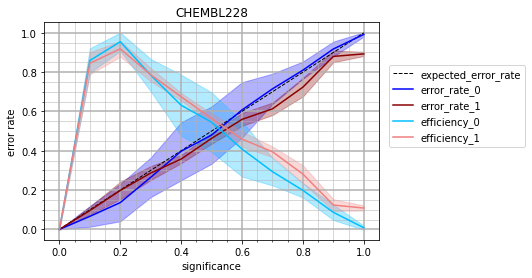

In [37]:
print("Calibration plot for internal CV using original calibration set:")
cross_validator.calibration_plot(endpoint=endpoint, averaged_evaluation_df=cross_validator.averaged_evaluation_df_cv)

Calibration plot for prediction of holdout set using original calibration set:


<module 'matplotlib.pyplot' from '/home/andrea/.local/miniconda/envs/recalibration_si/lib/python3.8/site-packages/matplotlib/pyplot.py'>

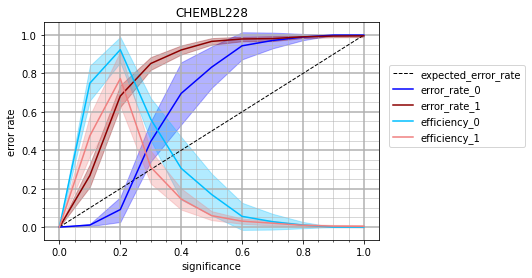

In [38]:
print("Calibration plot for prediction of holdout set using original calibration set:")
cross_validator.calibration_plot(endpoint=endpoint, averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_test)

In [39]:
# We would get an assertion error, if we try to plot the calibration plot using the updated calibration set, 
# since we have not updated it yet.
# cross_validator.calibration_plot(endpoint=endpoint, averaged_evaluation_df=cross_validator.averaged_evaluation_df_cal_update_1)

In [40]:
print(len(cross_validator.train_indices[0]))

880


### Update the calibration set within the crossvalidator
Note: here we show the first update step with X_update1/y_update1. We could add one more update step with X_update2/y_update2 as shown in the first part (without crossvalidation).

In [41]:
# For control, the 'updated number' is printed, which is the number under which the updated 
# model/predictions are saved. This is important since the number will be incremented
# automatically when another number is already used.
cross_validator.cross_validate_calibrate_update(X_update=X_update1, y_update=y_update1, X_test=X_holdout, y_test=y_holdout, steps=10, endpoint=endpoint)

In [42]:
cross_validator._evaluation_dfs.keys()

dict_keys(['cv', 'pred_test', 'cal_update_1'])

In [43]:
cross_validator._predictions.keys()

dict_keys(['cv', 'pred_test', 'cal_update_1'])

In [44]:
print(len(cross_validator.predictors))

5


Evaluating the predictions on the holdout set using the updated calibration set (averaged over all folds)

In [45]:
cross_validator.averaged_evaluation_df_cal_update_1[["validity mean", "efficiency mean", "accuracy mean", "significance_level"]]

,validity mean,efficiency mean,accuracy mean,significance_level
significance_level,,,,
0.0,1.0000,0.0000,0.0000,0.0
0.1,0.8802,0.4292,0.7288,0.1
0.2,0.7700,0.7046,0.6784,0.2
0.3,0.6654,0.9024,0.6524,0.3
0.4,0.5794,0.8880,0.6530,0.4
0.5,0.4804,0.7272,0.6634,0.5
0.6,0.3928,0.5666,0.7008,0.6
0.7,0.2974,0.4174,0.7236,0.7
0.8,0.2030,0.2836,0.7386,0.8


### Calibration plot for the holdout set using the updated calibration set

Calibration plot for prediction of holdout set using updated calibration set:


<module 'matplotlib.pyplot' from '/home/andrea/.local/miniconda/envs/recalibration_si/lib/python3.8/site-packages/matplotlib/pyplot.py'>

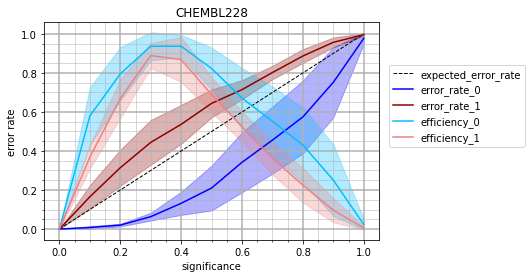

In [46]:
print("Calibration plot for prediction of holdout set using updated calibration set:")
cross_validator.calibration_plot(endpoint=endpoint, averaged_evaluation_df=cross_validator.averaged_evaluation_df_cal_update_1)

In [47]:
strategies = ["cv_original", "original", "update1"]
eval_df_columns = ["validity_bal mean", "efficiency_bal mean", "accuracy_bal mean", "significance_level"]

In [48]:
evaluation_measures = [m.split(" ")[0] for m in eval_df_columns[:-1]]
print(evaluation_measures)

['validity_bal', 'efficiency_bal', 'accuracy_bal']


In [49]:
evaluation_dfs_dict = {}
evaluation_dfs_dict["cv_original"] = cross_validator.averaged_evaluation_df_cv[eval_df_columns]
evaluation_dfs_dict["original"] = cross_validator.averaged_evaluation_df_pred_test[eval_df_columns]
evaluation_dfs_dict["update1"] = cross_validator.averaged_evaluation_df_cal_update_1[eval_df_columns]

### Scatter plot to compare different strategies

To compare balanced validity, balanced efficiency and balanced accuracy for the three strategies, they are plotted in a scatter plot.

(<module 'matplotlib.pyplot' from '/home/andrea/.local/miniconda/envs/recalibration_si/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <matplotlib.legend.Legend at 0x7f92aadc5a00>)

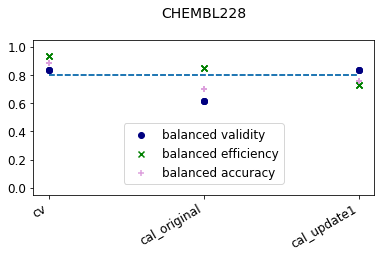

In [50]:
draw_scatter_plot_one_endpoint(endpoint, evaluation_dfs_dict, evaluation_measures=evaluation_measures)

### UMAP to analyse chemical space of subsets

A UMAP can be helpful to analyse the chemical space of the subsets. Ideally, the update and holdout sets cover a similar descriptor space.
In the first step, we create an embedding, in a second step, this will be plotted.

Note that, for the crossvalidation part, we only showed one step of updating with the update1 set. For our study, we updated the calibration set again, i.e. with update2 set and with the combined update1_and_2_set. Hence, the UMAP shows the descriptor space of all four subsets: training set, update1 set, update2 set, and holdout set.

In [51]:
embedding, colours_numbers = create_umap_data(
    chembl_id=endpoint, descriptors_df=data, thresholds=thresholds, n_neighbors=n_neighbors,
    min_distances=min_distances, distance_metric=distance_metric, dataset_colours=umap_colours)

desc chembio


2111


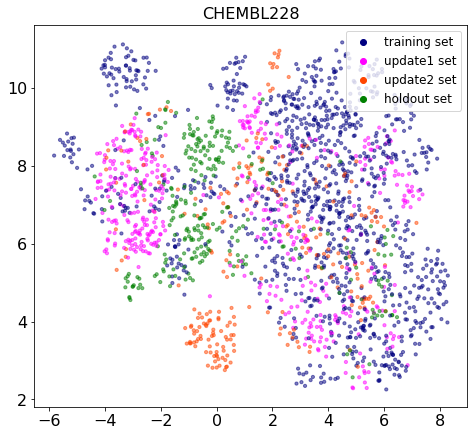

In [52]:
umap_plot = plot_umap(embedding, endpoint, colours_datasets=colours_numbers, umap_colours=umap_colours, n_neighbor=n_neighbors, min_distance=min_distances, distance_metric=distance_metric)